# How to use Coddora

Coddora is a simulation-trained deep learning model for detecting occupancy from CO2 rates in building rooms.<br>
It may be applied as a zero-shot classifier or you may fine-tune it with your own measured indoor CO2 data for better detection accuracy.<br> For zero-shot classification, we also provide a second version CoddoraRW, which may be more suitable in real-world applications.<br><br>
This file shows how to use Coddora.

In [14]:
import requests
import zipfile
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Load Coddora Model

Choose one of the following URLs to load your model from, or store it locally and load it via:<br> <i>tf.keras.models.load_model(model_path)</i>

In this example we load the Coddora model.<br>
You may also choose CoddoraRW, which was additionally trained on real-world data and may provide better results as a zero-shot classifier.

In [15]:
# URL for Coddora model
url = 'https://raw.githubusercontent.com/CCWI/Coddora/master/Models/coddora.zip'

# URL for CoddoraRW
#url = 'https://raw.githubusercontent.com/CCWI/Coddora/master/Models/coddoraRW.zip'

In [16]:
def load_model_from_url(url, extraction_path='./temporary_model_extraction'):
    
    try:
        # download and extract zipped model
        response = requests.get(url, timeout=60)

        if not os.path.exists(extraction_path):
            os.makedirs(extraction_path)

        zip_path = os.path.join(extraction_path, "model.zip")
        with open(zip_path, 'wb') as f:
            f.write(response.content)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extraction_path)
        model_path = os.path.join(extraction_path)
        
        # load model
        model = tf.keras.models.load_model(model_path)

        # remove temporary extraction path
        if os.path.exists(extraction_path):
            shutil.rmtree(extraction_path)
        
        print("Model loaded successfully")
        return model

    except requests.RequestException as e:
        print(f"Download failed: {str(e)}")
        return None
    except zipfile.BadZipFile:
        print("An Error occured while extracting the zip file")
        return None
    except Exception as e:
        print(f"Loading the model failed: {str(e)}")
        return None

model = load_model_from_url(url)

Model loaded successfully


In [17]:
model.summary()

Model: "cdblstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1D_layer1 (Conv1D)       multiple                  1200      
_________________________________________________________________
pooling_layer1 (MaxPooling1D multiple                  0         
_________________________________________________________________
conv1D_layer2 (Conv1D)       multiple                  30050     
_________________________________________________________________
pooling_layer2 (MaxPooling1D multiple                  0         
_________________________________________________________________
blstm_layer1 (Bidirectional) multiple                  40400     
_________________________________________________________________
blstm_layer2 (Bidirectional) multiple                  60400     
_________________________________________________________________
blstm_layer3 (Bidirectional) multiple                  6040

## Prepare Data Sample

#### 1. Sample of CO2 Timeseries

As an example, we choose a simple timeseries with linearly increasing CO2 values.<br>
Note: This is not a realistic behavior, but as the CO2 values are constantly increasing, we can expect that Coddora will detect occupany here.
<br><br>
Our sample has to be encoded as a <b>2D array</b> of <b>float values</b> with shape <b>(30, 1)</b><br>
representing the CO2 levels for each minute in a <b>30-min time range</b>.<br>
Make sure to meet this requirement when preparing your input samples from measured sensor data.

(30, 1)

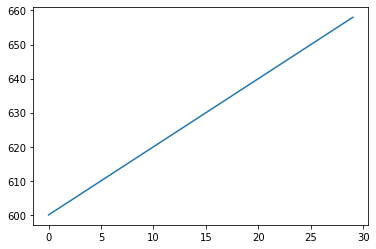

In [18]:
co2 = [[600.], [602.], [604.], [606.], [608.], [610.], [612.], [614.], [616.], [618.], [620.], [622.], [624.], [626.], [628.],
       [630.], [632.], [634.], [636.], [638.], [640.], [642.], [644.], [646.], [648.], [650.], [652.], [654.], [656.], [658.]]

plt.plot(co2)
np.shape(co2)

#### 2. Sample of Metadata

As a second input, the model requires the room's <b>volume</b> in m², <b>infiltration rate</b> in m³/s per m² facade and <b>occupation limit</b>.<br>


If the infiltration is unknown, we can simply estimate it<br>(according to https://www.ladybug.tools/honeybee-energy/docs/honeybee_energy.load.infiltration.html):<br>
- 0.0001 (m³/s per m² facade) - Tight building
- 0.0003 (m³/s per m² facade) - Average building
- 0.0006 (m³/s per m² facade) - Leaky building

In a modern building, we can assume a value of 0.0001.

For our example, we choose a room that measures 20 m² with a height of 3 m, which gives us a room volume of 60 m³.
Let's say the room is a single-person office and the building is relatively young, so we assume an infiltration of 0.0001 m³/sm². Then our metadata array looks like this:

In [19]:
metadata = [60,  0.0001, 1]  # [volume, infiltration, maxOccupants]

metadata

[60, 0.0001, 1]

Before we can use it, we have to <b>scale each value</b> to the range [0, 1] in accordance with the boundaries set for the simulations that Coddora was trained on.<br>
You may use the following functions:

In [20]:
def scale_data(data, min_domain, max_domain, min_feature=0, max_feature=1):
    '''
    Scales data by a defined domain minimum/maximum.
    Optionally the feature range can be adjusted - the default is [0, 1].
    '''
    return (data - min_domain) / (max_domain - min_domain) * (max_feature - min_feature) + min_feature

def scale_meta_features(meta_features):
    '''
    Scales each value in an array of meta features to the range [0, 1]. 
    Values outside the boundaries (min_domain, max_domain) are not allowed.
    :param meta_features: feature array [_volume, infiltration, maxOccupants]
    '''
    meta_features[0] = scale_data(meta_features[0], min_domain=9.6, max_domain=400)
    meta_features[1] = scale_data(meta_features[1], min_domain=0.000085, max_domain=0.00085)
    meta_features[2] = scale_data(meta_features[2], min_domain=1, max_domain=12)
    return meta_features

scaled_metadata = scale_meta_features(metadata)

scaled_metadata

[0.1290983606557377, 0.0196078431372549, 0.0]

####  3. Final Input Tuple

The Coddora model requires two inputs: one for the <b>timeseries data (input 1)</b> and another for the scaled <b>metadata</b> about the room <b>(input 2)</b>.<br>
Now that our data is prepared, we create a joint input tuple using a numpy array for the samples for input 1 and another numpy array for input 2.<br> In our case, the arrays contain only a single sample each.

In [21]:
input_tuple = (np.array([co2]), np.array([scaled_metadata]))

The final input tuple must be a 2-tuple, where the first element is the timeseries input with a shape of <b>(batch_size, 30, 1)</b> <br>and the second element is the metadata input with a shape of <b>(batch_size, 3)</b>.<br>
In our case, the batch size is only one:

In [22]:
np.shape(input_tuple[0]), np.shape(input_tuple[1])

((1, 30, 1), (1, 3))

## Make a Prediction

To make a prediction, we call the <b>predict</b> function of the model and pass the tuple that contains both input samples.<br> The result can be interpreted as a probability of presence at the end of the timeseries, ranging from 0 to 1.

In [25]:
model.predict(input_tuple)

array([[0.6565976]], dtype=float32)

To determine the predicted state of occupancy, we compare probability predictions to the prediction threshold of 0.5:

In [26]:
model.predict(input_tuple) > 0.5

array([[ True]])

Coddora is detecting occupancy in this example.

## More example code:

For fine-tuning Coddora, you may use the code from <i>3-Model_Training/2_Retrain_on_Real_World_Data.ipynb</i><br>
For evaluation on a real-world dataset, see <i>4-Evaluation</i>